In [1]:
import os
import sys
sys.path.append(os.getcwd())
from models.mlp import *
from models.hebbian import *
from models.feedback import *
from models.hybrid import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision, torch
import numpy as np

## Training Functions

In [2]:
def download_dataset(ds_name=None, train_prop=0.8, keep_prop=0.5):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

    if ds_name is None or ds_name == 'MNIST':
        download = os.path.exists("../data/MNIST/")
        full_train_set = torchvision.datasets.MNIST(
            root="../data/", train=True, download=download, transform=transform
        )
        full_test_set = torchvision.datasets.MNIST(
            root="../data/", train=False, transform=transform
        )
    elif ds_name == 'EMNIST':
        # Might change split to "balanced" for balanced characters if performance is low
        download = os.path.exists("../data/EMNIST/")

        full_train_set = torchvision.datasets.EMNIST(
            root="../data/", split="byclass", download=download, transform=transform
        )
        full_test_set = torchvision.datasets.EMNIST(
            root="../data/", split="byclass", download=download, transform=transform
        )
    else:
        download = os.path.exists("../data/omniglot-py/")

        full_train_set = torchvision.datasets.Omniglot(
            root="../data/", download=download, transform=transform
        )
        full_test_set = torchvision.datasets.Omniglot(
            root="../data/", download=download, transform=transform
        )
    train_set, valid_set, _ = torch.utils.data.random_split(
        full_train_set, [train_prop * keep_prop, (1 - train_prop) * keep_prop, 1-keep_prop]
    )
    test_set, _ = torch.utils.data.random_split(
        full_test_set, [keep_prop, 1 - keep_prop]
    )

    print("Number of examples retained:")
    print(f"  {len(train_set)} (training)")
    print(f"  {len(valid_set)} (validation)")
    print(f"  {len(test_set)} (test)")

    return train_set, valid_set, test_set

train_set, valid_set, test_set = download_dataset("EMNIST")

####### TRAINING FUNCTIONS ########


def train_model(
    model,
    train_loader,
    valid_loader,
    optimizers,
    loss_type="NLL",
    num_epochs=5,
):
    results_dict = {
        "train_loss": list(),
        "valid_loss": list(),
        "m1_train_loss": list(),
        "m1_valid_loss": list(),
        "m2_train_loss": list(),
        "m2_valid_loss": list(),
        "train_acc": list(),
        "valid_acc": list(),
        "m1_train_acc": list(),
        "m1_valid_acc": list(),
        "m2_train_acc": list(),
        "m2_valid_acc": list(),
    }

    for e in tqdm(range(num_epochs)):
        no_train = True if e == 0 else False  # to get a baseline
        epoch_dict = train_epoch(
            model,
            train_loader,
            valid_loader,
            loss_type=loss_type, 
            optimizers=optimizers,
            no_train=no_train,
        )

        for key, result in epoch_dict.items():
            if key in results_dict.keys() and isinstance(results_dict[key], list):
                results_dict[key].append(epoch_dict[key])
            else:
                results_dict[key] = result  # copy latest

    return results_dict

def train_epoch(
    model,
    train_loader,
    valid_loader,
    optimizers,
    loss_type="NLL",
    no_train=False,
    mirror=False,
    m_lr=0.01,
    noise_amplitude=1,
):

    if loss_type == "NLL":
        criterion = torch.nn.NLLLoss()
        do_log = True
    else:
        criterion = torch.nn.CrossEntropyLoss()
        do_log = False

    epoch_results_dict = dict()
    for dataset in ["train", "valid"]:
        for sub_str in ["correct_by_class", "seen_by_class"]:
            epoch_results_dict[f"{dataset}_{sub_str}"] = {
                i: 0 for i in range(model.num_outputs)
            }

    opt_combined, opt_m1, opt_m2 = optimizers
    model.train()
    train_losses, train_acc = list(), list()
    m1_acc, m2_acc = list(), list()
    m1_train_losses, m2_train_losses = list(), list()

    for X, y in train_loader:
        opt_combined.zero_grad()
        opt_m1.zero_grad()
        opt_m2.zero_grad()

        if not no_train:
            # Train combined model
            y_pred, _, _ = model(X, y=y)
            loss_combined = criterion(y_pred, y)
            if do_log:
                loss_combined = torch.log(loss_combined)
            loss_combined.backward()
            opt_combined.step()

            # Train m1
            opt_m1.zero_grad()
            _, m1_pred, _ = model(X, y=y)
            loss_m1 = criterion(m1_pred, y)
            if do_log:
                loss_m1 = torch.log(loss_m1)
            loss_m1.backward()
            opt_m1.step()

            # Train m2
            opt_m2.zero_grad()
            _, _, m2_pred = model(X, y=y)
            loss_m2 = criterion(m2_pred, y)
            if do_log:
                loss_m2 = torch.log(loss_m2)
            loss_m2.backward()
            opt_m2.step()
        else:
            y_pred, m1_pred, m2_pred = model(X, y=y)
            loss_combined = criterion(y_pred, y)
            loss_m1 = criterion(m1_pred, y)
            loss_m2 = criterion(m2_pred, y)
            if do_log:
                loss_combined, loss_m1, loss_m2 = (
                    torch.log(loss_combined),
                    torch.log(loss_m1),
                    torch.log(loss_m2),
                )

        with torch.no_grad():
            y_pred, m1_pred, m2_pred = model(X, y=y)
            acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
            acc_m1 = (torch.argmax(m1_pred, axis=1) == y).sum() / len(y)
            acc_m2 = (torch.argmax(m2_pred, axis=1) == y).sum() / len(y)
            train_acc.append(acc.item() * len(y))
            m1_acc.append(acc_m1.item() * len(y))
            m2_acc.append(acc_m2.item() * len(y))
        train_losses.append(loss_combined.item() * len(y))
        m1_train_losses.append(loss_m1.item() * len(y))
        m2_train_losses.append(loss_m2.item() * len(y))

        # update_results_by_class_in_place(
        #     y,
        #     y_pred.detach() if not no_train else y_pred_eval.detach(),
        #     epoch_results_dict,
        #     dataset="train",
        #     num_classes=model.num_outputs,
        # )

        if mirror:
            model.mirror(X, m_lr, noise_amplitude)

    num_items_train = len(train_loader.dataset)
    epoch_results_dict["train_loss"] = np.sum(train_losses) / num_items_train
    epoch_results_dict["train_acc"] = (
        np.sum(train_acc) / num_items_train * 100
    )

    epoch_results_dict["m1_train_loss"] = (np.sum(m1_train_losses) / num_items_train)
    epoch_results_dict["m2_train_loss"] = (np.sum(m2_train_losses) / num_items_train)
    epoch_results_dict["m1_train_acc"] = (
        np.sum(train_acc) / num_items_train * 100
    )
    epoch_results_dict["m2_train_acc"] = (
        np.sum(train_acc) / num_items_train * 100
    )

    model.eval()
    valid_losses, valid_acc = list(), list()
    valid_m1_acc, valid_m2_acc = list(), list()
    m1_valid_losses, m2_valid_losses = list(),list() 
    with torch.no_grad():
        for X, y in valid_loader:
            y_pred, m1_pred, m2_pred = model(X)

            loss_combined = criterion(y_pred, y)
            loss_m1 = criterion(m1_pred, y)
            loss_m2 = criterion(m2_pred, y)
            m1_valid_losses.append(loss_m1.item() * len(y))
            m2_valid_losses.append(loss_m2.item() * len(y))

            acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
            acc_m1 = (torch.argmax(m1_pred, axis=1) == y).sum() / len(y)
            acc_m2 = (torch.argmax(m2_pred, axis=1) == y).sum() / len(y)
            valid_losses.append(loss_combined.item() * len(y))
            valid_acc.append(acc.item() * len(y))
            valid_m1_acc.append(acc_m1.item() * len(y))
            valid_m2_acc.append(acc_m2.item() * len(y))
            update_results_by_class_in_place(
                y, y_pred.detach(), epoch_results_dict, dataset="valid"
            )

    num_items_valid = len(valid_loader.dataset)
    epoch_results_dict["valid_loss"] = np.sum(valid_losses) / num_items_valid
    epoch_results_dict["valid_acc"] = (np.sum(valid_acc) / num_items_valid * 100)
    epoch_results_dict["m1_valid_loss"] = (np.sum(m1_valid_losses) / num_items_valid)
    epoch_results_dict["m2_valid_loss"] = (np.sum(m2_valid_losses) / num_items_valid)
    epoch_results_dict["m1_valid_acc"] = (
        np.sum(valid_m1_acc) / num_items_valid * 100
    )
    epoch_results_dict["m2_valid_acc"] = (
        np.sum(valid_m2_acc) / num_items_valid * 100
    )

    return epoch_results_dict

def update_results_by_class_in_place(
    y, y_pred, result_dict, dataset="train", num_classes=10
):
    y_pred = np.argmax(y_pred, axis=1)
    for i in result_dict[f"{dataset}_seen_by_class"].keys():
        idxs = np.where(y == int(i))[0]
        result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

        num_correct = int(sum(y[idxs] == y_pred[idxs]))
        result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct, correct_m1, correct_m2 = 0, 0, 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            y_pred, m1_pred, m2_pred = model(X)
            p, m1_p, m2_p = (
                torch.argmax(y_pred, axis=1),
                torch.argmax(m1_pred, axis=1),
                torch.argmax(m2_pred, axis=1),
            )
            correct += (p == y).sum().item()
            correct_m1 += (m1_p == y).sum().item()
            correct_m2 += (m2_p == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    acc_m1 = 100 * correct_m1 / total
    acc_m2 = 100 * correct_m2 / total

    return acc, acc_m1, acc_m2



Number of examples retained:
  279173 (training)
  69793 (validation)
  348966 (test)


## Plotting functions

In [3]:
####### PLOTTING FUNCTIONS ########
def get_plotting_color(dataset="train", model_idx=None):
    if model_idx is not None:
        dataset = None

    if model_idx == 0 or dataset == "train":
        color = "#1F77B4"  # blue
    elif model_idx == 1 or dataset == "valid":
        color = "#FF7F0E"  # orange
    elif model_idx == 2 or dataset == "test":
        color = "#2CA02C"  # green
    else:
        if model_idx is not None:
            raise NotImplementedError("Colors only implemented for up to 3 models.")
        else:
            raise NotImplementedError(
                f"{dataset} dataset not recognized. Expected 'train', 'valid' "
                "or 'test'."
            )

    return color


def plot_results(results_dict, num_classes=10, ax=None, prefix=None, model=None):
    """
    Function for plotting losses and accuracies across learning.

    Arguments:
    - results_dict (dict): Dictionary storing results across epochs on training
      and validation data.
    - num_classes (float, optional): Number of classes, used to calculate chance
      accuracy.
    - ax (plt subplot, optional): Axis on which to plot results. If None, a new
      axis will be created.

    Returns:
    - ax (plt subplot): Axis on which results were plotted.
    """

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 3.5))

    loss_ax = ax
    acc_ax = None

    chance = 100 / num_classes

    plotted = False
    for result_type in ["loss", "acc"]:
        for dataset in ["train", "valid"]:
            key = f"{dataset}_{result_type}"
            if prefix is not None:
                key = f"{prefix}{dataset}_{result_type}"
            if result_type == "loss":
                ylabel = "Loss"
                plot_ax = loss_ax
                ls = None
            elif result_type == "acc":
                if acc_ax is None:
                    acc_ax = ax.twinx()
                    acc_ax.spines[["right"]].set_visible(True)
                    acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
                    acc_ax.set_ylim(-5, 105)
                ylabel = "Accuracy (%)"
                plot_ax = acc_ax
                ls = "dashed"
            else:
                raise RuntimeError(f"{result_type} result type not recognized.")

            data = results_dict[key]
            plot_ax.plot(
                data,
                ls=ls,
                label=dataset,
                alpha=0.8,
                color=get_plotting_color(dataset),
            )
            plot_ax.set_ylabel(ylabel)
            plotted = True

    if plotted:
        ax.legend(loc="center left")
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
        ymin, ymax = ax.get_ylim()
        if ymin > 0:
            ymin = 0
            pad = (ymax - ymin) * 0.05
            ax.set_ylim(ymin - pad, ymax + pad)

    else:
        raise RuntimeError("No data found to plot.")

    if model is not None:
        ax.set_title(f"{model} Performance across learning")
    else:
        ax.set_title(f"Hybrid model performance across learning")
    ax.set_xlabel("Epoch")
    return ax

def plot_scores_per_class(results_dict, num_classes=10, ax=None):
    """
    Function for plotting accuracy scores for each class.

    Arguments:
    - results_dict (dict): Dictionary storing results across epochs on training
      and validation data.
    - num_classes (int, optional): Number of classes in the data.
    - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
      axis will be created.

    Returns:
    - ax (plt subplot): Axis on which accuracies were plotted.
    """

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 3))

    avgs = list()
    ax.set_prop_cycle(None)  # reset color cycle
    for s, dataset in enumerate(["train", "valid"]):
        correct_by_class = results_dict[f"{dataset}_correct_by_class"]
        seen_by_class = results_dict[f"{dataset}_seen_by_class"]
        xs, ys = list(), list()
        for i, total in seen_by_class.items():
            xs.append(i + 0.3 * (s - 0.5))
            if total == 0:
                ys.append(np.nan)
            else:
                ys.append(100 * correct_by_class[i] / total)

        avg_key = f"avg_{dataset}_accuracies"
        if avg_key in results_dict.keys():
            ax.axhline(
                results_dict[avg_key][-1],
                ls="dashed",
                alpha=0.8,
                color=get_plotting_color(dataset),
            )

        ax.bar(
            xs,
            ys,
            label=dataset,
            width=0.3,
            alpha=0.8,
            color=get_plotting_color(dataset),
        )

    ax.set_xticks(range(num_classes))
    ax.set_xlabel("Class")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Class scores")
    ax.set_ylim(-5, 105)

    chance = 100 / num_classes
    ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

    ax.legend()

    return ax

def plot_weights(MLP, shared_colorbar=False):
    """
    Function for plotting model weights and biases before and after learning.

    Arguments:
    - MLP (torch model): Model for which to plot weights and biases.
    - shared_colorbar (bool, optional): If True, one colorbar is shared for all
        parameters.

    Returns:
    - ax (plt subplot array): Axes on which weights and biases were plotted.
    """

    param_names = MLP.list_parameters()

    params_images = dict()
    pre_means = dict()
    post_means = dict()
    vmin, vmax = np.inf, -np.inf
    for param_name in param_names:
        layer, param_type = param_name.split("_")
        init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
        separator = np.full((1, init_params.shape[-1]), np.nan)
        last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
        diff_params = last_params - init_params

        params_image = np.vstack(
            [init_params, separator, last_params, separator, diff_params]
        )
        vmin = min(vmin, np.nanmin(params_image))
        vmax = min(vmax, np.nanmax(params_image))

        params_images[param_name] = params_image
        pre_means[param_name] = init_params.mean()
        post_means[param_name] = last_params.mean()

    nrows = len(param_names)
    gridspec_kw = dict()
    if len(param_names) == 4:
        gridspec_kw["height_ratios"] = [5, 1, 5, 1]
        cbar_label = "Weight/bias values"
    elif len(param_names) == 2:
        gridspec_kw["height_ratios"] = [5, 5]
        cbar_label = "Weight values"
    else:
        raise NotImplementedError(
            "Expected 2 parameters (weights only) or "
            f"4 parameters (weights and biases), but found {len(param_names)}"
        )

    if shared_colorbar:
        nrows += 1
        gridspec_kw["height_ratios"].append(1)
    else:
        vmin, vmax = None, None

    fig, axes = plt.subplots(
        nrows,
        1,
        figsize=(6, 2.5 * nrows), 
        gridspec_kw=gridspec_kw,
        constrained_layout=True,
    )

    for i, (param_name, params_image) in enumerate(params_images.items()):
        layer, param_type = param_name.split("_")
        layer_str = "First" if layer == "lin1" else "Second"
        param_str = "weights" if param_type == "weight" else "biases"

        axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
        im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
        if not shared_colorbar:
            cbar = fig.colorbar(im, ax=axes[i], aspect=10)
            cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
            cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

        if param_type == "weight":
            axes[i].set_xlabel("Input dim.")
            axes[i].set_ylabel("Output dim.")
        axes[i].spines[["left", "bottom"]].set_visible(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    if shared_colorbar:
        cax = axes[-1]
        cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
        cax.set_xlabel(cbar_label)

    return axes

## Model training

In [11]:
# Model
NUM_HIDDEN = 30
NUM_INPUTS = np.prod(train_set.dataset.data[0].shape)
NUM_OUTPUTS = len(train_set.dataset.classes)  # number of classes
ACTIVATION = "relu"  # output constrained between 0 and 1
BIAS = True
MLP1 = FAPerceptron(
    num_inputs=NUM_INPUTS,
    num_outputs=NUM_OUTPUTS,
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
)
NUM_HIDDEN = 15
ACTIVATION = "relu"
MLP2 = FAPerceptron(
    num_inputs=NUM_INPUTS,
    num_outputs=NUM_OUTPUTS,
    num_hidden=NUM_HIDDEN,
    activation_type=ACTIVATION,
    bias=BIAS,
)

hybrid_MLP = HybridMLP(MLP1, MLP2, "concat")

# Dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False
)
LR = 0.01

param_dict = dict(hybrid_MLP.named_parameters())
hybrid_params = [
    param_dict[name] for name in hybrid_MLP.list_parameters() if name in param_dict
]
opt = BasicOptimizer(hybrid_params, lr=LR)
opt_m1 = BasicOptimizer(MLP1.parameters(), lr=LR)
opt_m2 = BasicOptimizer(MLP2.parameters(), lr=LR)

## Training model

In [12]:

NUM_EPOCHS = 5

results_dict = train_model(
    hybrid_MLP,
    train_loader,
    valid_loader,
    optimizers=(opt, opt_m1, opt_m2),
    loss_type='CELoss',
    num_epochs=NUM_EPOCHS,
)
test_acc, m1_acc, m2_acc = evaluate_accuracy(hybrid_MLP, test_loader)

100%|██████████| 5/5 [02:06<00:00, 25.30s/it]


In [13]:
test_acc, m1_acc, m2_acc

(49.99684783044766, 67.7644813534843, 59.14788260174343)

## Plotting results

In [14]:
subset = {k: v for k, v in results_dict.items() if "m1" not in k and "m2" not in k}
subset_m1 = {k.removeprefix("m1_"): v for k, v in results_dict.items() if "m1" in k}
subset_m2 = {k.removeprefix("m2_"): v for k, v in results_dict.items() if "m2" in k}

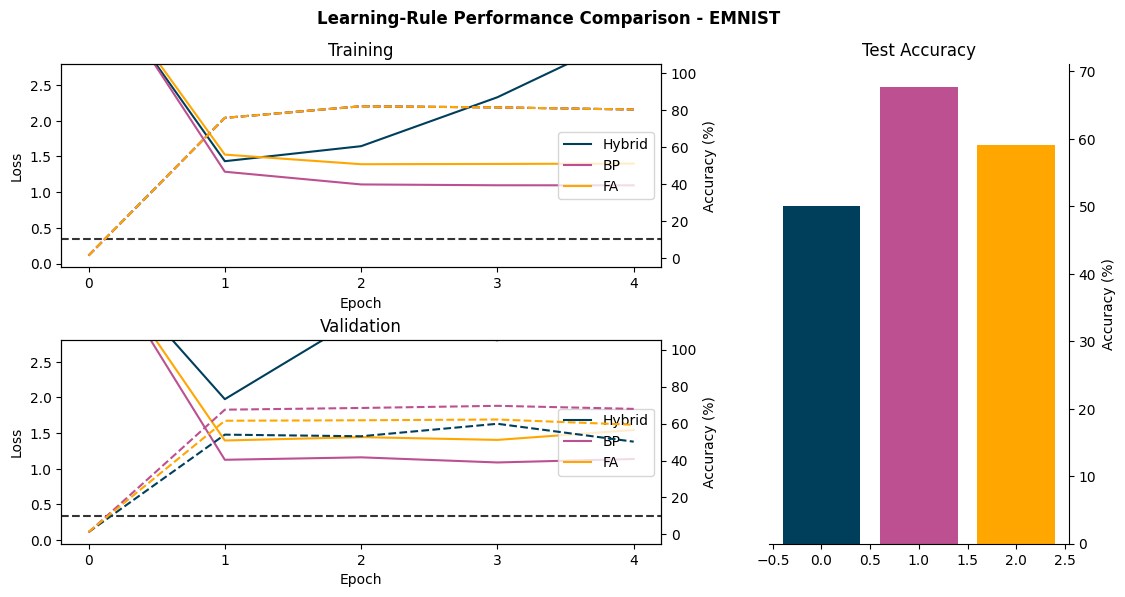

In [15]:
epochs = 5
num_classes = 10

chance = 100 / num_classes


def create_grid(fig, spec):
    axes = []
    for row in range(spec.nrows):
        for col in range(spec.ncols):
            axes.append(fig.add_subplot(spec[row, col]))
    return axes


fig = plt.figure(figsize=(13, 6))
fig.suptitle("Learning-Rule Performance Comparison - EMNIST", weight="bold", y=0.94)

widths = [1, 0.5]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths)

train_ax = fig.add_subplot(spec[0, 0])
valid_ax = fig.add_subplot(spec[1, 0])
acc_ax = fig.add_subplot(spec[:, 1])

fig.subplots_adjust(wspace=0.24, hspace=0.36, top=0.85, bottom=0.05)

train_ax.set_xticks(np.arange(epochs))
train_ax.set_xlabel("Epoch")
train_ax.set_ylabel("Loss")
train_ax.set_ylim(-0.05, 2.8)
train_ax.set_title("Training")


acc_train = train_ax.twinx()
acc_train.spines[["right"]].set_visible(True)
acc_train.axhline(chance, ls="dashed", color="k", alpha=0.8)
acc_train.set_ylim(-5, 105)
acc_train.set_ylabel("Accuracy (%)")

# train_ax.spines[['top']].set_visible(False)
# train_ax.spines.bottom.set(linewidth=2)
# train_ax.spines.left.set(linewidth=2)
# train_ax.spines.right.set(linewidth=2)

valid_ax.set_xticks(np.arange(epochs))
valid_ax.set_xlabel("Epoch")
valid_ax.set_ylabel("Loss")
valid_ax.set_ylim(-0.05, 2.8)
valid_ax.set_title("Validation")

acc_valid = valid_ax.twinx()
acc_valid.spines[["right"]].set_visible(True)
acc_valid.axhline(chance, ls="dashed", color="k", alpha=0.8)
acc_valid.set_ylim(-5, 105)
acc_valid.set_ylabel("Accuracy (%)")

dicts = [subset, subset_m1, subset_m2]
labels = ["Hybrid", "BP", "FA"]
colors = ["#003f5c", "#bc5090", "#ffa600"]
accuracies = [test_acc, m1_acc, m2_acc]

bars = []

for data_dict, label, color in zip(dicts, labels, colors):
    train_ax.plot(data_dict["train_loss"], label=label, color=color)
    acc_train.plot(
        data_dict["train_acc"], label=label, color=color, ls="dashed"
    )

    valid_ax.plot(data_dict["valid_loss"], label=label, color=color)
    acc_valid.plot(
        data_dict["valid_acc"], label=label, color=color, ls="dashed"
    )

acc_ax.bar(np.arange(len(accuracies)), height=accuracies, color=colors, label=labels)
acc_ax.yaxis.set_label_position("right")
acc_ax.yaxis.tick_right()
acc_ax.set_ylabel("Accuracy (%)")
acc_ax.spines[["top", "left"]].set_visible(False)
acc_ax.set_title("Test Accuracy")


train_ax.legend(loc="center right")
valid_ax.legend(loc="center right")

array([<Axes: title={'center': 'First linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>,
       <Axes: title={'center': 'First linear layer biases (pre, post and diff)'}>,
       <Axes: title={'center': 'Second linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>,
       <Axes: title={'center': 'Second linear layer biases (pre, post and diff)'}>],
      dtype=object)

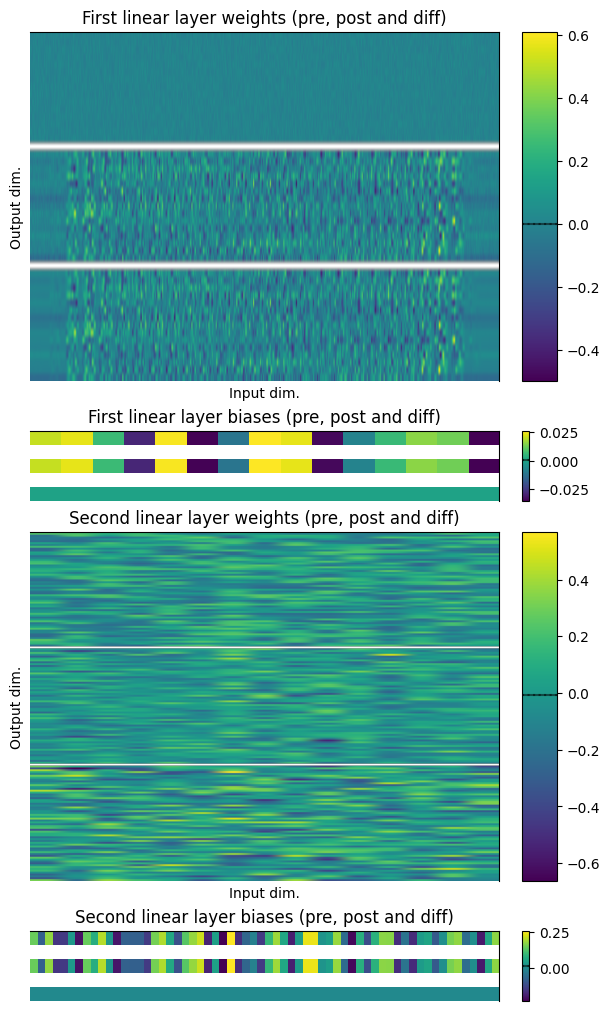

In [16]:
plot_weights(MLP2)

array([<Axes: title={'center': 'First linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>,
       <Axes: title={'center': 'First linear layer biases (pre, post and diff)'}>,
       <Axes: title={'center': 'Second linear layer weights (pre, post and diff)'}, xlabel='Input dim.', ylabel='Output dim.'>,
       <Axes: title={'center': 'Second linear layer biases (pre, post and diff)'}>],
      dtype=object)

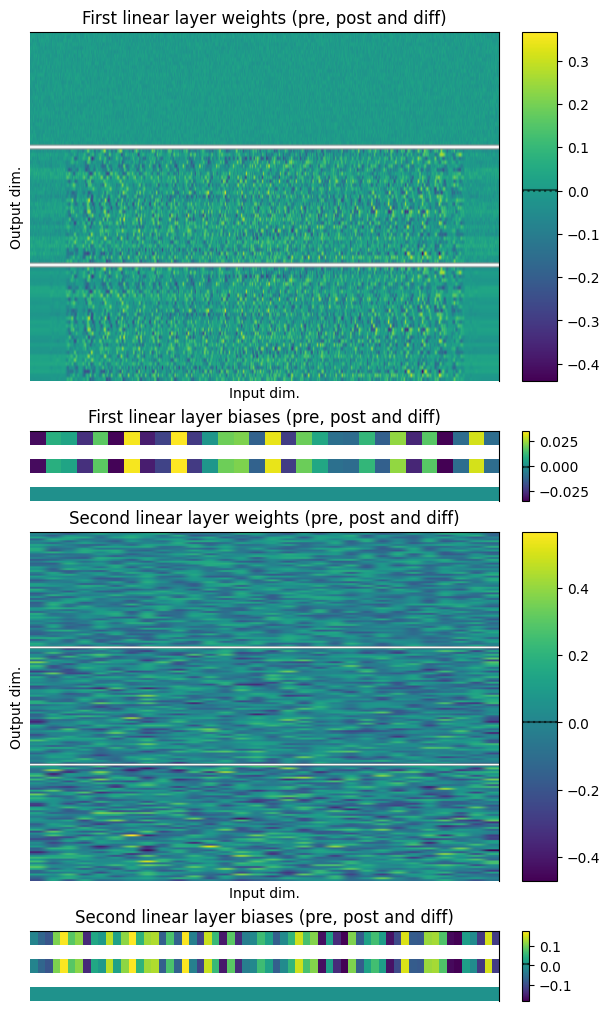

In [17]:
plot_weights(MLP1)